In [6]:
%load_ext autoreload
%autoreload 2

from src.utils.env_creation import create_tree, create_init
from src.utils.mouselab_jas import MouselabJas
from src.utils.data_classes import MouselabConfig, Action
from src.utils.utils import sigma_to_tau, tau_to_sigma
import numpy as np
from simulation import run_simulation
from src.policy.jas_voc_policy import JAS_voc_policy
from src.policy.jas_policy import RandomPolicy, ExhaustivePolicy, RandomNPolicy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import GPyOpt
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Fixed from paper
num_projects = 5
num_criteria = 6
weights = [0.0206795, 0.0672084, 0.2227102, 0.1067428, 0.4665054, 0.1161537]
expert_stds = [1.5616618964384956, 1.449172525995787, 1.5205992970609392, 1.5469422429523034, 1.511270787760881, 1.455189251463794]
expert_taus = sigma_to_tau(np.array(expert_stds))

mu = [3.6, 3.1666666666666665, 3.6, 3.1333333333333333, 3.6666666666666665, 2.3]
sigma = [1.3544307876819288, 1.2617266038997932, 1.3796551293211172, 1.2521246311585852, 1.5161960871578068, 0.9523111632886272]

init = create_init([0]+(mu*num_projects), [0]+(sigma*num_projects))
expert_costs = [0.002]*6

config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=False, max_actions=5)
env = MouselabJas(config=config)

In [5]:
# Cost weight 0.5798921379230035 for discrete with max 5 actions
voc_policy = JAS_voc_policy(discrete_observation=True, cost_weight=0.5798921379230035)
res = run_simulation(env, voc_policy, start_seed=11, n=10)
print(len(res))
res.agg(["mean", "std"])

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

10


,reward,actions,seed,runtime,true_reward,expected_reward
mean,4.050447,3.500000,15.50000,0.304688,4.050447,3.675345
std,0.359223,1.354006,3.02765,0.110792,0.359223,0.073368


In [4]:
voc_policy = JAS_voc_policy(discrete_observations=False, cost_weight=0.2)
res = run_simulation(env, voc_policy, start_seed=11, n=10)
print(len(res))
res.agg(["mean", "std"])

100%|██████████| 10/10 [00:04<00:00,  2.30it/s]

10


,reward,actions,seed,runtime,true_reward,expected_reward
mean,4.004477,5.800000,15.50000,0.429688,4.004477,3.691934
std,0.456692,0.421637,3.02765,0.042473,0.456692,0.091003


In [14]:
voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=0.05)
res = run_simulation(env, voc_policy, start_seed=1, n=200)
res.agg(["mean", "std"])[["reward", "expected_reward", "actions"]]

100%|██████████| 200/200 [05:26<00:00,  1.63s/it]


,reward,expected_reward,actions
mean,4.108619,3.764095,8.095000
std,0.686664,0.151127,5.028159


In [5]:
voc_policy = JAS_voc_policy(discrete_observations=True, discrete_depth=1, cost_weight=0.5)
res = run_simulation(env, voc_policy, start_seed=0, n=5)
res["expected_reward"].mean(), res["true_reward"].mean()

100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


(3.7755826824732823, 3.906706417934256)

In [9]:
n_eval = 100
restarts = 5
steps = 25

def blackbox(W):
    voc_policy = JAS_voc_policy(discrete_observations=True, cost_weight=W[0,0])
    res = run_simulation(env, voc_policy, start_seed=0, n=n_eval)
    print(W, res["expected_reward"].mean(), res["true_reward"].mean())
    return - (res["expected_reward"].mean())
    
np.random.seed(123456)

space = [{'name': 'cost_weight', 'type': 'continuous', 'domain': (0,1)}]
feasible_region = GPyOpt.Design_space(space = space)
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, restarts)
objective = GPyOpt.core.task.SingleObjective(blackbox)
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=restarts,verbose=False)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# --- Stop conditions
max_time  = None
tolerance = 1e-6     # distance between two consecutive observations        

# Run the optimization
max_iter  = steps
time_start = time.time()
train_tic = time_start
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=True)

W = np.array([bo.x_opt])[0,0]
train_toc = time.time()

print("\nSeconds:", train_toc-train_tic)
print("Weights:", W)

100%|██████████| 100/100 [01:30<00:00,  1.11it/s]


[[0.12696983]] 3.724207883724077 4.070134490293525


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


[[0.96671784]] 3.697812200549826 3.908535886070014


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


[[0.26047601]] 3.724207883724077 4.070134490293525


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


[[0.89723652]] 3.710102061875902 3.9111677790802046


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


[[0.37674972]] 3.7255179983427116 4.070154490293525


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


[[0.47311062]] 3.7255179983427116 4.070154490293525
num acquisition: 1, time elapsed: 89.44s


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


[[0.67200542]] 3.727468146613378 4.069332059829
num acquisition: 2, time elapsed: 176.58s


100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


[[0.]] 3.724987304732433 4.068574490293525
num acquisition: 3, time elapsed: 286.16s


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


[[0.6245991]] 3.727468146613378 4.069332059829
num acquisition: 4, time elapsed: 373.59s


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


[[0.64888298]] 3.727468146613378 4.069332059829
num acquisition: 5, time elapsed: 458.52s


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


[[0.7146829]] 3.727468146613378 4.069332059829
num acquisition: 6, time elapsed: 544.00s


100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


[[0.57989214]] 3.7279183459353766 4.0693120598290005
num acquisition: 7, time elapsed: 646.66s


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


[[0.55707598]] 3.7279183459353766 4.0693120598290005
num acquisition: 8, time elapsed: 730.97s


100%|██████████| 100/100 [01:25<00:00,  1.18it/s]


[[0.56805]] 3.7279183459353766 4.0693120598290005
num acquisition: 9, time elapsed: 816.21s


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


[[0.76120514]] 3.727468146613378 4.069332059829
num acquisition: 10, time elapsed: 905.55s


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


[[0.05591745]] 3.724207883724077 4.070134490293525
num acquisition: 11, time elapsed: 994.50s


100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


[[0.53539444]] 3.7279183459353766 4.0693120598290005
num acquisition: 12, time elapsed: 1079.02s


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


[[0.32436357]] 3.724207883724077 4.070134490293525
num acquisition: 13, time elapsed: 1165.69s


100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


[[0.54433833]] 3.7279183459353766 4.0693120598290005
num acquisition: 14, time elapsed: 1253.47s


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


[[0.74131477]] 3.727468146613378 4.069332059829
num acquisition: 15, time elapsed: 1339.72s


100%|██████████| 100/100 [01:33<00:00,  1.07it/s]


[[0.19383891]] 3.724207883724077 4.070134490293525
num acquisition: 16, time elapsed: 1433.42s


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


[[0.79411071]] 3.727468146613378 4.069332059829
num acquisition: 17, time elapsed: 1518.81s


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


[[0.59414769]] 3.7279183459353766 4.0693120598290005
num acquisition: 18, time elapsed: 1603.55s


100%|██████████| 100/100 [01:32<00:00,  1.09it/s]


[[0.5204079]] 3.7279183459353766 4.0693120598290005
num acquisition: 19, time elapsed: 1695.77s


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


[[0.52679033]] 3.7279183459353766 4.0693120598290005
num acquisition: 20, time elapsed: 1783.20s


100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


[[0.50954796]] 3.7255179983427116 4.070154490293525
num acquisition: 21, time elapsed: 1885.26s


100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


[[0.43211513]] 3.7255179983427116 4.070154490293525
num acquisition: 22, time elapsed: 1981.89s


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


[[0.82460616]] 3.727468146613378 4.069332059829
num acquisition: 23, time elapsed: 2066.63s


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


[[0.69363157]] 3.727468146613378 4.069332059829
num acquisition: 24, time elapsed: 2152.13s


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]

[[0.81104956]] 3.727468146613378 4.069332059829
num acquisition: 25, time elapsed: 2236.83s

Seconds: 2682.9701557159424
Weights: 0.5798921379230035


In [10]:
n_eval = 100
restarts = 5
steps = 25

def blackbox(W):
    voc_policy = JAS_voc_policy(discrete_observations=False, cost_weight=W[0,0])
    res = run_simulation(env, voc_policy, start_seed=0, n=n_eval)
    print(W, res["expected_reward"].mean(), res["true_reward"].mean())
    return - (res["expected_reward"].mean())
    
np.random.seed(123456)

space = [{'name': 'cost_weight', 'type': 'continuous', 'domain': (0,1)}]
feasible_region = GPyOpt.Design_space(space = space)
initial_design = GPyOpt.experiment_design.initial_design('random', feasible_region, restarts)
objective = GPyOpt.core.task.SingleObjective(blackbox)
model = GPyOpt.models.GPModel(exact_feval=True,optimize_restarts=restarts,verbose=False)
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(feasible_region)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, feasible_region, optimizer=aquisition_optimizer)
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
bo = GPyOpt.methods.ModularBayesianOptimization(model, feasible_region, objective, acquisition, evaluator, initial_design)

# --- Stop conditions
max_time  = None
tolerance = 1e-6     # distance between two consecutive observations        

# Run the optimization
max_iter  = steps
time_start = time.time()
train_tic = time_start
bo.run_optimization(max_iter = max_iter, max_time = max_time, eps = tolerance, verbosity=True)

W = np.array([bo.x_opt])[0,0]
train_toc = time.time()

print("\nSeconds:", train_toc-train_tic)
print("Weights:", W)

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


[[0.12696983]] 3.676248754431715 3.980543353129198


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


[[0.96671784]] 3.401163603333332 3.427881016653363


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


[[0.26047601]] 3.674949194754314 3.9563924001589132


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


[[0.89723652]] 3.609530310377128 3.7818315316172058


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


[[0.37674972]] 3.660518961665437 3.935935431461447


100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


[[0.1339241]] 3.676248754431715 3.980543353129198
num acquisition: 1, time elapsed: 48.20s


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


[[0.31461843]] 3.660518961665437 3.935935431461447
num acquisition: 2, time elapsed: 81.21s


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


[[0.71270421]] 3.6632919816020277 3.935955431461447
num acquisition: 3, time elapsed: 117.65s


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


[[0.81258036]] 3.6625574381605905 3.9359754314614475
num acquisition: 4, time elapsed: 150.03s


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


[[0.55772447]] 3.660518961665437 3.935935431461447
num acquisition: 5, time elapsed: 182.09s


100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


[[0.]] 3.6762287544317154 3.9805233531291977
num acquisition: 6, time elapsed: 229.63s


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


[[0.4693162]] 3.660518961665437 3.935935431461447
num acquisition: 7, time elapsed: 262.66s


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


[[0.63824016]] 3.6632919816020277 3.935955431461447
num acquisition: 8, time elapsed: 296.12s


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


[[0.20818603]] 3.674949194754314 3.9563924001589132
num acquisition: 9, time elapsed: 347.47s


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


[[0.04652745]] 3.6762287544317154 3.9805233531291977
num acquisition: 10, time elapsed: 399.63s


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


[[0.08050494]] 3.676248754431715 3.980543353129198
num acquisition: 11, time elapsed: 450.49s


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


[[0.23739048]] 3.674949194754314 3.9563924001589132
num acquisition: 12, time elapsed: 505.45s


100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


[[0.01927985]] 3.6762287544317154 3.9805233531291977
num acquisition: 13, time elapsed: 560.96s


100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


[[0.16962991]] 3.674949194754314 3.9563924001589132
num acquisition: 14, time elapsed: 609.17s


100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


[[0.1010973]] 3.676248754431715 3.980543353129198
num acquisition: 15, time elapsed: 665.10s


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


[[0.06312374]] 3.6762287544317154 3.9805233531291977
num acquisition: 16, time elapsed: 722.09s


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


[[0.76218301]] 3.6632919816020277 3.935955431461447
num acquisition: 17, time elapsed: 759.12s


 67%|██████▋   | 67/100 [00:27<00:12,  2.64it/s]

In [9]:
# Run comparisons between discrete VOC calculation for different versions of the environment

def compare(config, n=100, seed=0):
    env = MouselabJas(config=config)
    voc_policy_disc = JAS_voc_policy(discrete_observations=True)
    voc_policy_disc_1 = JAS_voc_policy(discrete_observations=True, discrete_depth=1)
    #voc_policy_disc_2 = JAS_voc_policy(discrete_observations=True, discrete_depth=2)
    voc_policy = JAS_voc_policy(discrete_observations=False)
    res_voc = run_simulation(env, voc_policy, start_seed=seed, n=n)
    res_voc["algorithm"] = "MGPO_cont"
    res_voc_disc = run_simulation(env, voc_policy_disc, start_seed=seed, n=n)
    res_voc_disc["algorithm"] = "MGPO_disc_old"
    res_voc_disc1 = run_simulation(env, voc_policy_disc_1, start_seed=seed, n=n)
    res_voc_disc1["algorithm"] = "MGPO_disc_d1"
    # res_voc_disc2 = run_simulation(env, voc_policy_disc_2, start_seed=seed, n=n)
    # res_voc_disc2["algorithm"] = "MGPO_disc_d2"
    res = pd.concat([res_voc, res_voc_disc, res_voc_disc1])
    return res

In [11]:
# Standard setup
config = MouselabConfig(num_projects=num_projects, num_criterias=num_criteria, expert_costs=expert_costs, expert_taus=expert_taus, init=init, criteria_scale=[1 for weight in weights], term_belief=False)
res = compare(config, n=100)
res.groupby("algorithm").agg(["mean", "std"])

100%|██████████| 100/100 [05:18<00:00,  3.18s/it]


reward           actions             seed             \
                    mean       std    mean        std  mean        std   
algorithm                                                                
MGPO_cont      21.887407  2.908221   30.15  14.275341  49.5  29.011492   
MGPO_disc_d1   20.614276  2.748784   14.25   9.016679  49.5  29.011492   
MGPO_disc_old  20.493104  3.214186   10.08   6.201466  49.5  29.011492   

                runtime           true_reward           expected_reward  \
                   mean       std        mean       std            mean   
algorithm                                                                 
MGPO_cont      4.151562  1.942538   21.887407  2.908221       21.026890   
MGPO_disc_d1   3.147656  1.867932   20.614276  2.748784       20.799079   
MGPO_disc_old  2.476406  1.532426   20.493104  3.214186       20.645934   

                         
                    std  
algorithm                
MGPO_cont      0.879394  
MGPO_disc_d1   0.560703  
MGPO_disc_old  0.470721

In [12]:
res.groupby("algorithm").agg(["mean", "std"])[["expected_reward", "true_reward"]]

expected_reward           true_reward          
                         mean       std        mean       std
algorithm                                                    
MGPO_cont           21.026890  0.879394   21.887407  2.908221
MGPO_disc_d1        20.799079  0.560703   20.614276  2.748784
MGPO_disc_old       20.645934  0.470721   20.493104  3.214186

In [12]:
# Higher cost
config = MouselabConfig(num_projects=num_projects, num_criterias=num_criteria, expert_costs=[cost*10 for cost in expert_costs], expert_taus=expert_taus, init=init, criteria_scale=[1 for weight in weights], term_belief=False)
res = compare(config)
res.groupby("algorithm").agg(["mean", "std"])

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


reward           actions            seed              runtime  \
                mean       std    mean       std  mean        std      mean   
algorithm                                                                     
MGPO       21.299387  3.210390   17.95  8.819601  49.5  29.011492  2.150469   
MGPO_disc  20.680366  2.812661    7.88  4.209849  49.5  29.011492  0.684688   

                    true_reward           expected_reward            
                std        mean       std            mean       std  
algorithm                                                            
MGPO       1.037320   20.510562  0.741526       21.299387  3.210390  
MGPO_disc  0.374674   20.429795  0.483453       20.680366  2.812661

In [17]:
res.groupby("algorithm").agg(["mean", "std"])

reward           actions              seed               runtime  \
               mean       std    mean        std   mean         std      mean   
algorithm                                                                       
MGPO       4.019096  0.649313  27.693  13.597413  499.5  288.819436  3.285000   
MGPO_disc  4.072416  0.633514   7.709   4.478434  499.5  288.819436  0.494531   

                    true_reward           expected_reward            
                std        mean       std            mean       std  
algorithm                                                            
MGPO       1.573218    3.734444  0.208692        4.019096  0.649313  
MGPO_disc  0.264765    3.753304  0.146468        4.072416  0.633514

Text(0, 0.5, 'Actions')

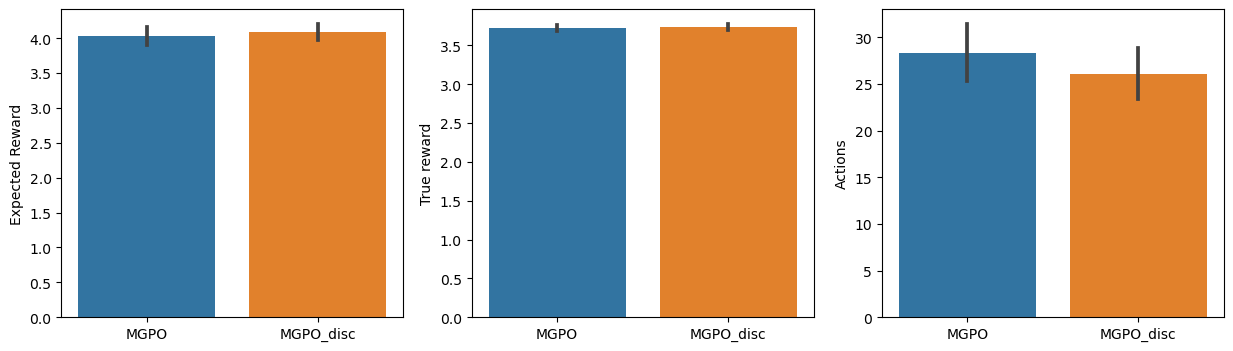

In [10]:


fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=False, sharey=False)
axes = axes.flatten()

g = sns.barplot(data=res, x="algorithm", y="expected_reward", ax=axes[0])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Expected Reward")

g = sns.barplot(data=res, x="algorithm", y="true_reward", ax=axes[1])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("True reward")

g = sns.barplot(data=res, x="algorithm", y="actions", ax=axes[2])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Actions")

In [25]:
voc_policy = JAS_voc_policy()
random_policy = RandomPolicy()
exhaustive_policy = ExhaustivePolicy()
random_6_policy = RandomNPolicy(N=6)
random_12_policy = RandomNPolicy(N=12)

In [26]:
res_random = run_simulation(env, random_policy, n=100)
res_exhaustive = run_simulation(env, exhaustive_policy, n=100)
res_random_6 = run_simulation(env, random_6_policy, n=100)
res_random_12 = run_simulation(env, random_12_policy, n=100)
res_voc = run_simulation(env, voc_policy, n=100)

res_voc["algorithm"] = "MGPO"
res_exhaustive["algorithm"] = "Exhaustive"
res_random["algorithm"] = "Random"
res_random_6["algorithm"] = "Random 6"
res_random_12["algorithm"] = "Random 12"
res = pd.concat([res_voc, res_random_6, res_exhaustive, res_random, res_random_12])

In [ ]:
res = []
for cost in [0.001, 0.002, 0.004]:
    expert_costs = cost*6
    config = MouselabConfig(num_projects, num_criteria, expert_costs, expert_taus, init, criteria_scale=weights, term_belief=True)
    env = MouselabJas(config=config)

    res_random = run_simulation(env, random_policy, n=10)
    res_exhaustive = run_simulation(env, exhaustive_policy, n=10)
    res_random_6 = run_simulation(env, random_6_policy, n=10)
    res_random_12 = run_simulation(env, random_12_policy, n=10)
    res_voc = run_simulation(env, voc_policy, n=10)

    res_voc["algorithm"] = "MGPO"
    res_exhaustive["algorithm"] = "Exhaustive"
    res_random["algorithm"] = "Random"
    res_random_6["algorithm"] = "Random 6"
    res_random_12["algorithm"] = "Random 12"
    tmp = pd.concat([res_voc, res_random_6, res_exhaustive, res_random, res_random_12])
    tmp["Cost"] = cost
    res.append(tmp)
df_cost = pd.concat(res)

In [18]:
res[["reward", "actions", "algorithm"]].groupby("algorithm").agg(["mean", "std"])

reward           actions           
                mean       std    mean        std
algorithm                                        
Exhaustive  3.603097  0.335080  181.00   0.000000
MGPO        3.945299  0.240611   11.81   5.241048
Random      3.654527  0.311977   86.48  49.990601
Random 12   3.591397  0.207531   13.00   0.000000
Random 6    3.498768  0.184110    7.00   0.000000

Text(0, 0.5, 'Actions')

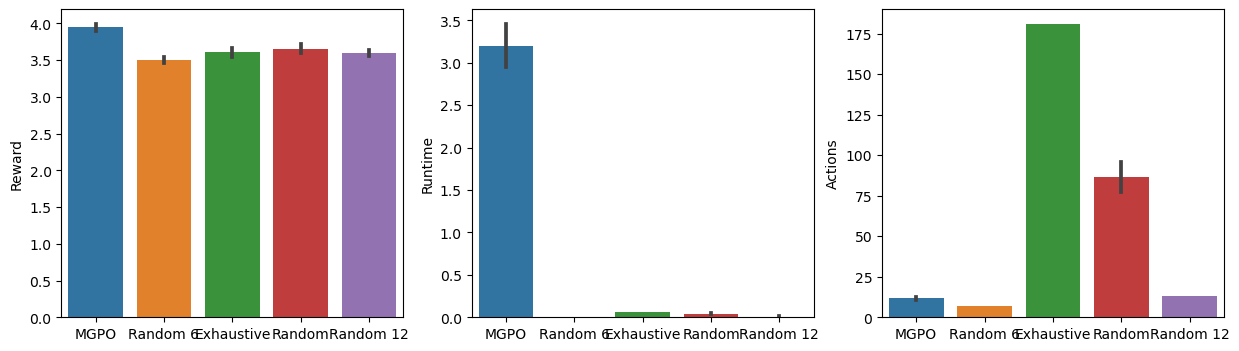

In [19]:

fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=False, sharey=False)
axes = axes.flatten()

g = sns.barplot(data=res, x="algorithm", y="reward", ax=axes[0])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Reward")

g = sns.barplot(data=res, x="algorithm", y="runtime", ax=axes[1])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Runtime")

g = sns.barplot(data=res, x="algorithm", y="actions", ax=axes[2])
g.set_title("")
g.set_xlabel("")
g.set_ylabel("Actions")